# Feature Training Experiments

In this notebook we analyse results obtained from the training sets experiments. The experimental design is as follows:

2. Let $m$ represent the machine learning model where $m$ $\in$ `["ADA", "LR", "DT", "RF"]`
3. Let $full$, $train$ and $test$ represent the full, training & testing subsets respectively. $train$ and $test$ are $0.75$ and $0.25$ of $full$ respectively
4. Let $train_{n}$ be sub-subsets of the training subset where `n` $\in$ `[0.1, 1.0]` representing the fraction of the data used
5. Let $m\prime_{n}$ be the model trained using $train_{n}$
6. Let $\hat{y}_{n, m\prime}$ be the predictions obtained from $m\prime_{n}$ on $test$. **Note that unlike the feature sets experiment, we use the same testing data here**
7. Let $d$ represent the group fairness metric where $d$ $\in$ `["DI", "SPD"]`
7. Let $v_{train, n, d}$ be data fairness metrics calculated using $train_{n}$. **Note that we do not compute fairness metrics from both subsets, because in this experiment the test subset remains unchanged**
1. Let $v_{n, m\prime, d}$ be the model fairness metrics calculated using $\hat{y}_{n, m\prime}$
1. We can reduce the granularity a bit for the analysis by considering the fairness metrics across the sub-subsets. Let $v_{train, d}$ and $v_{m\prime, d}$ represent the fairness metrics across the sub-subsets.

The objective is to analyse the following:
2. Relationship between $v_{train, d}$ and $v_{m\prime, d}$

Our hypothesis is that $v_{train, d}$ and $v_{m\prime, d}$ have some form of relationship. Another way of formulating the above statement is that the two random variables have similar distribution.

We employ two types of tests to verify our hypothesis:
1. Correlation and
2. Linear regression

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import shapiro, chi2
from sklearn.linear_model import LinearRegression

ROOTDIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATADIR = os.path.join(ROOTDIR, "data")
sys.path.insert(0, ROOTDIR)


In [3]:
import glob
from src.data import process

frames = [pd.read_csv(frame) for frame in glob.glob(os.path.join(DATADIR, "exp-training-sets-*-50.csv"))]
data = pd.concat(frames)
data = data[data["privileged"] == "None"]
process(data)
data.shape

(45600, 26)

In [4]:
data["dataset_label"] = data["dataset_label"] + "-" + data["protected"].str.lower()
data["dataset_label"].unique()

array(['adult-race', 'bank-age', 'adult-sex', 'german-sex', 'compas-sex',
       'compas-race', 'meps-race', 'german-age'], dtype=object)

In [5]:
data.dtypes

model                             object
TNR                              float64
average_abs_odds_difference      float64
subset_label                      object
true_positive_rate_difference    float64
TPR                              float64
disparate_impact                 float64
PPV                              float64
FPR                              float64
num_negatives                    float64
TP                               float64
FN                               float64
f1                               float64
accuracy                         float64
iteration                          int64
FP                               float64
theil_index                      float64
FNR                              float64
base_rate                        float64
dataset_label                     object
frac                             float64
num_positives                    float64
TN                               float64
privileged                        object
statistical_pari

### Test for normality
In this section we validate that the random variables in our experiment are normally distributed. We employ two methods:

1. QQ plot and
2. shapiro-wilk test

#### QQ Plots
In this section we visually investigate if the distribution of the data & model fairness metrics are normally distributed.

We generate two figures, one for each fairness metric. Within each metric, we generate a 2x8 grid of plots, each row containing 2 QQ plots (one each for $v_{train, d}$ and $v_{m\prime, d}$).

For simplicity, we limit our analysis to the DI fairness metric & the RF classifier.

In [9]:
# in this cell I am doing some manual checks to make
# sure I am sampling the data correctly by checking
# the shape of the dataset

# each vector should contain num_features*50 points

datasets = data["dataset_label"].unique().tolist()
models = data["model"].unique().tolist()
models.remove("None")

for dataset in datasets:
    _ = data[
        (data["dataset_label"] == dataset) &
        (data["subset_label"] == "train") &
        (data["model"] == "None")
    ]
    assert _.shape[0] == len(_["frac"].unique().tolist())*50


    for model in models:
        _ = data[
            (data["dataset_label"] == dataset) &
            (data["model"] == model)
        ]
    assert _.shape[0] == len(_["frac"].unique().tolist())*50

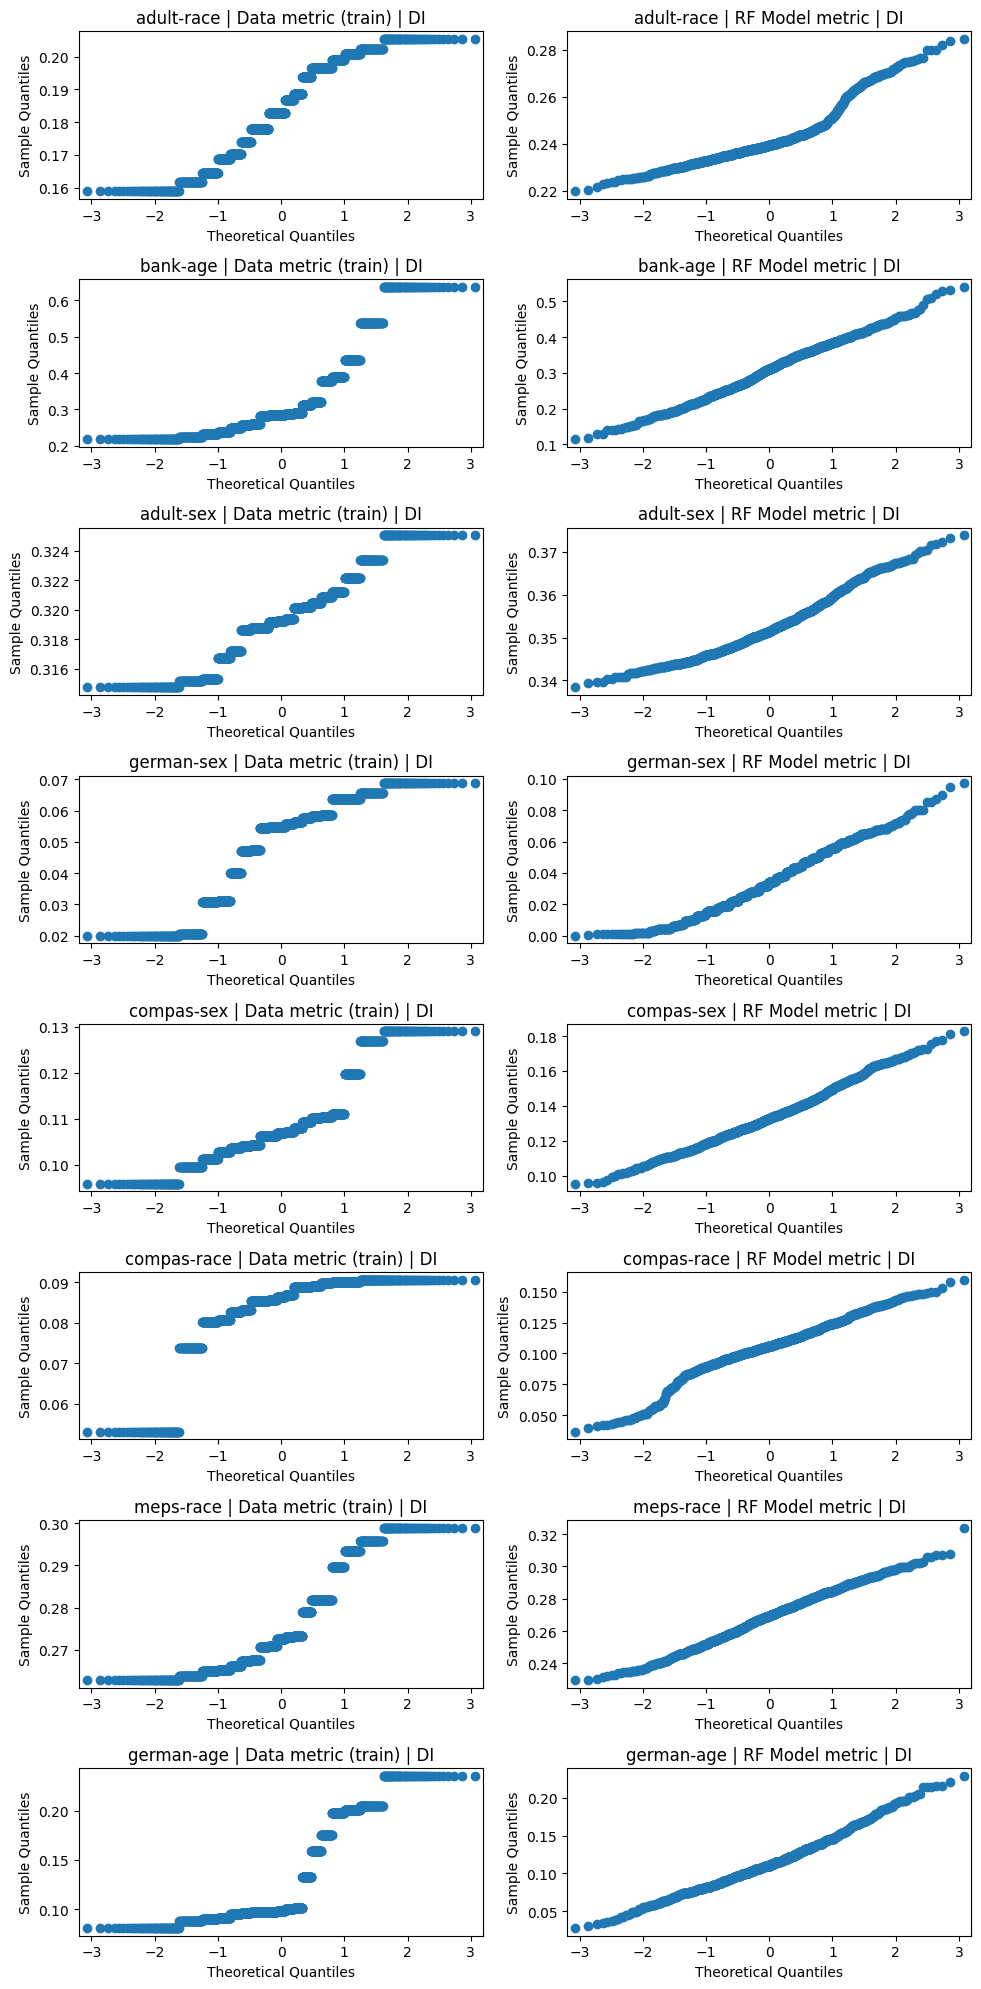

In [15]:
fig, axs = plt.subplots(
    nrows=len(datasets),
    ncols=2,
    figsize=(10,20),
)

for idx, dataset in enumerate(datasets):
    _ = data[
        (data["dataset_label"] == dataset) &
        (data["subset_label"] == "train") &
        (data["model"] == "None")
    ]

    ax = axs[idx, 0]
    ax.set_title("{} | Data metric (train) | DI".format(dataset))
    sm.qqplot(
        data=_["disparate_impact"],
        ax=ax,
    )

    _ = data[
        (data["dataset_label"] == dataset) &
        (data["model"] == "randomforestclassifier")
    ]

    ax = axs[idx, 1]
    ax.set_title("{} | RF Model metric | DI".format(dataset))
    sm.qqplot(
        data=_["disparate_impact"],
        ax=ax,
    )

fig.tight_layout()

### [Shapiro-wilk test](#sec-shapiro)
In this section we employ the Shapiro-Wilk test for normality. The test is as follows:

- $H_o$: the population is normally distributed
- $H_1$: the population is not normally distributed

In [18]:
di_pvalues = {
    "dataset": [],
    "model": [],
    "shapiro": [],
}

for dataset in datasets:
    _ = data[
        (data["dataset_label"] == dataset) &
        (data["subset_label"] == "train") &
        (data["model"] == "None")
    ]
    di_pvalues["dataset"].append(dataset)
    di_pvalues["model"].append("None")
    di_pvalues["shapiro"].append(shapiro(_["disparate_impact"])[1])

    for model in models:
        _ = data[
            (data["dataset_label"] == dataset) &
            (data["model"] == model)
        ]
        di_pvalues["dataset"].append(dataset)
        di_pvalues["model"].append(model)
        di_pvalues["shapiro"].append(shapiro(_["disparate_impact"])[1])

di_pvalues = pd.DataFrame(data=di_pvalues)
di_pvalues


,dataset,model,shapiro
0,adult-race,None,2.777531e-19
1,adult-race,logisticregression,3.678584e-23
2,adult-race,decisiontreeclassifier,3.849097e-13
3,adult-race,adaboostclassifier,7.887696e-22
4,adult-race,randomforestclassifier,1.067149e-25
5,bank-age,None,1.222038e-33
6,bank-age,logisticregression,1.099417e-35
7,bank-age,decisiontreeclassifier,2.819252e-09
8,bank-age,adaboostclassifier,8.493099e-29
9,bank-age,randomforestclassifier,8.706216e-04


In [19]:
print("di_pvalues shape: {}".format(di_pvalues.shape))

di_pvalues[di_pvalues["shapiro"] >= 0.05]

di_pvalues shape: (40, 3)


,dataset,model,shapiro


We observe that **none of the populations are normal**.

## Correlation
In this section we employ correlation to test if there is a relationship between the data & model metrics. From the section above, we note that the distribution of the populations are not normal.

We use the Spearman's correlation since it does not assume normality & is robust to outliers.

We will create individual tables for each fairness metric (DI & SPD).

In [21]:
corr = pd.DataFrame(columns=datasets)
_frames = []

# grab the train data fairness metrics
_ = data[
    (data["model"] == "None") &
    (data["subset_label"] == "train")
]
_frames.append(_)

# grab the model metrics
_ = data[(data["model"] != "None")]
_frames.append(_)

frames = pd.concat(_frames)

for d in datasets:
    _ = frames[
            (frames["dataset_label"] == d)
        ]
    _pivots = []
    for n in _["frac"].unique().tolist():
        _pivots.append(pd.pivot(
            data=_[_["frac"] == n],
            index="iteration",
            columns="model",
            values="disparate_impact",
        ))
        # select the first column
        corr["{}".format(d)] = pd.concat(_pivots).corr(method="spearman").loc[:, "None"]

corr

,adult-race,bank-age,adult-sex,german-sex,compas-sex,compas-race,meps-race,german-age
model,,,,,,,,
None,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
adaboostclassifier,0.261404,0.671347,0.440544,0.357174,0.282456,-0.065040,-0.450877,-0.293111
decisiontreeclassifier,-0.162126,0.276059,0.311783,0.220075,0.446374,0.280289,0.570188,-0.116229
logisticregression,0.547368,0.960492,0.489474,-0.004390,0.297499,0.552632,-0.621053,0.373684
randomforestclassifier,0.062343,0.624316,0.041268,0.141422,0.641336,0.466155,0.319670,0.250075


Text(50.72222222222221, 0.5, '')

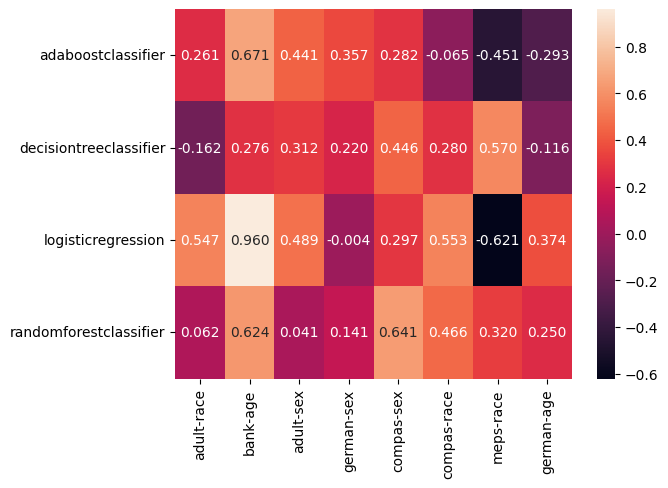

In [22]:
fig, ax = plt.subplots()

sns.heatmap(
    data=corr.drop("None"),
    annot=True,
    fmt=".3f",
    ax=ax,
)
ax.set_ylabel(None)

## Linear Regression
In this section we employ linear regression to analyse relationship between the data & model fairness metrics.

We collect the following metrics:

1. min, max & avg for $v_{train, d}$
2. min, max & avg for $v_{m\prime, d}$
3. coefficient(slope) of the linear regression model

In [23]:
d = {
    "dataset": [],
    "model": [],
    "x_min": [],
    "x_max": [],
    "x_mean": [],
    "y_min": [],
    "y_max": [],
    "y_mean": [],
    "slope": [],
}

for dataset in datasets:
    x = frames[
        (frames["dataset_label"] == dataset) &
        (frames["model"] == "None")
    ]["disparate_impact"]

    for model in models:
        y = frames[
            (frames["dataset_label"] == dataset) &
            (frames["model"] == model)
        ]["disparate_impact"]
        mod = LinearRegression()
        mod.fit(
            X=x.values.reshape(-1, 1),
            y=y.values.reshape(-1, 1),
        )

        d["dataset"].append(dataset)
        d["model"].append(model)
        d["x_min"].append(x.min())
        d["x_max"].append(x.max())
        d["x_mean"].append(x.mean())
        d["y_min"].append(y.min())
        d["y_max"].append(y.max())
        d["y_mean"].append(y.mean())
        d["slope"].append(mod.coef_.ravel()[0])

reg = pd.DataFrame(data=d)
reg

,dataset,model,x_min,x_max,x_mean,y_min,y_max,y_mean,slope
0,adult-race,logisticregression,0.158890,0.205421,0.183650,0.234193,0.288195,0.257498,0.433012
1,adult-race,decisiontreeclassifier,0.158890,0.205421,0.183650,0.141525,0.231194,0.181155,-0.191845
2,adult-race,adaboostclassifier,0.158890,0.205421,0.183650,0.208610,0.279695,0.234413,0.334590
3,adult-race,randomforestclassifier,0.158890,0.205421,0.183650,0.219707,0.284526,0.241995,0.010401
4,bank-age,logisticregression,0.217396,0.636781,0.322129,0.432099,1.000000,0.568241,1.180385
5,bank-age,decisiontreeclassifier,0.217396,0.636781,0.322129,0.121405,0.696744,0.366281,0.430210
6,bank-age,adaboostclassifier,0.217396,0.636781,0.322129,0.329990,0.752838,0.451960,0.927917
7,bank-age,randomforestclassifier,0.217396,0.636781,0.322129,0.113888,0.540264,0.307675,0.294974
8,adult-sex,logisticregression,0.314710,0.325059,0.319285,0.354147,0.367557,0.360775,0.767897
9,adult-sex,decisiontreeclassifier,0.314710,0.325059,0.319285,0.291104,0.330490,0.307977,1.088716
